In [33]:
import re
import io
import glob
import nltk
import string
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import math

# Part 1: Twitter Network Analysis

## Exercise 1: Build the network of retweets
We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should be able to reuse many of the functions you have written as part of the exercises during the previous weeks):

* **Consider the 200 most recent tweets written by each member of the house (use the files [here](https://github.com/suneman/socialgraphs2019/tree/master/files/data_twitter/tweets_2019.zip/). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "*RT @originalAuthor:*", where "*originalAuthor*" is the handle of the user whose content was retweeted (and the part of the text you want to extract).**

*According to Twitter offical page (https://help.twitter.com/en/managing-your-account/twitter-username-rules), Twitter handles can only contain letters, digits and underscores. This explains the regular expression pattern we choose to use below.*

In [2]:
# define a function to find the original author and the content of ONE member's retweets 

def find_retweets(path):
    
    # first, read the tweets of a particular member
    # io module is chosen for its encoding parameter as utf-8 encoding is needed
    f = io.open(path, mode="r", encoding="utf-8").read()
    
    # then, use regex to find all retweets of this member
    # result is stored in a tuple of tuples of the following format: 
    # ((originalAuthor1, content1),(originalAuthor2, content2),...)
    tup = re.findall(r"RT @([a-zA-Z0-9_]+): (.*)", f) # letter, digit and underscore

    return tup

* For each retweet, check if the handle retweeted is, in fact, the handle of a member of the house. If yes, keep it. If no, discard it.

In [3]:
# load Twitter handles of the members of the house
members_df = pd.read_csv("H115_tw_2019.csv")
members_df.head()

,WikiPageName,Party,State,Name,tw_id,tw_name
0,Don_Young,Republican,Alaska,Don Young,3.700727e+07,repdonyoung
1,Jim_Sensenbrenner,Republican,Wisconsin,Jim Sensenbrenner,8.516214e+08,JimPressOffice
2,Hal_Rogers,Republican,Kentucky,Hal Rogers,5.504018e+08,RepHalRogers
3,Chris_Smith_(New_Jersey_politician),Republican,New Jersey,Chris Smith,1.289319e+09,RepChrisSmith
4,Steny_Hoyer,Democratic,Maryland,Steny Hoyer,2.201209e+07,LeaderHoyer


*Create three dictionaries for convertering between various member information:*

In [4]:
# some data extraction to build dictionary
tw_name = members_df.tw_name.tolist()
party=members_df.Party.tolist()
wiki_name=members_df.WikiPageName.tolist()

In [5]:
# dictionary that maps wikiname to party
wikiName_party_dic={}

for i in range(len(wiki_name)):
    wikiName_party_dic[wiki_name[i]] = party[i]

wikiName_party_dic

{'Don_Young': 'Republican',
 'Jim_Sensenbrenner': 'Republican',
 'Hal_Rogers': 'Republican',
 'Chris_Smith_(New_Jersey_politician)': 'Republican',
 'Steny_Hoyer': 'Democratic',
 'Marcy_Kaptur': 'Democratic',
 'Pete_Visclosky': 'Democratic',
 'Peter_DeFazio': 'Democratic',
 'John_Lewis_(civil_rights_leader)': 'Democratic',
 'Fred_Upton': 'Republican',
 'Nancy_Pelosi': 'Democratic',
 'Frank_Pallone': 'Democratic',
 'Eliot_Engel': 'Democratic',
 'Nita_Lowey': 'Democratic',
 'Richard_Neal': 'Democratic',
 'José_E._Serrano': 'Democratic',
 'David_Price_(American_politician)': 'Democratic',
 'Rosa_DeLauro': 'Democratic',
 'Maxine_Waters': 'Democratic',
 'Jerrold_Nadler': 'Democratic',
 'Jim_Cooper': 'Democratic',
 'Ken_Calvert': 'Republican',
 'Jim_Clyburn': 'Democratic',
 'Anna_Eshoo': 'Democratic',
 'Gene_Green': 'Democratic',
 'Alcee_Hastings': 'Democratic',
 'Peter_T._King': 'Republican',
 'Carolyn_Maloney': 'Democratic',
 'Lucille_Roybal-Allard': 'Democratic',
 'Bobby_Rush': 'Democratic

In [6]:
# dictionary that maps tw_name to party
twName_party_dic={}

for i in range(len(tw_name)):
    twName_party_dic[tw_name[i]] = party[i]

twName_party_dic

{'repdonyoung': 'Republican',
 'JimPressOffice': 'Republican',
 'RepHalRogers': 'Republican',
 'RepChrisSmith': 'Republican',
 'LeaderHoyer': 'Democratic',
 'RepMarcyKaptur': 'Democratic',
 'RepVisclosky': 'Democratic',
 'RepPeterDeFazio': 'Democratic',
 'repjohnlewis': 'Democratic',
 'RepFredUpton': 'Republican',
 'SpeakerPelosi': 'Democratic',
 'FrankPallone': 'Democratic',
 'RepEliotEngel': 'Democratic',
 'NitaLowey': 'Democratic',
 'RepRichardNeal': 'Democratic',
 'RepJoseSerrano': 'Democratic',
 'RepDavidEPrice': 'Democratic',
 'rosadelauro': 'Democratic',
 'RepMaxineWaters': 'Democratic',
 'RepJerryNadler': 'Democratic',
 'repjimcooper': 'Democratic',
 'KenCalvert': 'Republican',
 'WhipClyburn': 'Democratic',
 'RepAnnaEshoo': 'Democratic',
 'RepMarkGreen': 'Democratic',
 'RepHastingsFL': 'Democratic',
 'RepPeteKing': 'Republican',
 'RepMaloney': 'Democratic',
 'RepRoybalAllard': 'Democratic',
 'RepBobbyRush': 'Democratic',
 'BobbyScott': 'Democratic',
 'BennieGThompson': 'Democra

In [7]:
# dictionary that maps wikiname to tw_name
wikiname_twName_dic={}

for i in range(len(tw_name)):
    wikiname_twName_dic[wiki_name[i]] = tw_name[i]

wikiname_twName_dic

{'Don_Young': 'repdonyoung',
 'Jim_Sensenbrenner': 'JimPressOffice',
 'Hal_Rogers': 'RepHalRogers',
 'Chris_Smith_(New_Jersey_politician)': 'RepChrisSmith',
 'Steny_Hoyer': 'LeaderHoyer',
 'Marcy_Kaptur': 'RepMarcyKaptur',
 'Pete_Visclosky': 'RepVisclosky',
 'Peter_DeFazio': 'RepPeterDeFazio',
 'John_Lewis_(civil_rights_leader)': 'repjohnlewis',
 'Fred_Upton': 'RepFredUpton',
 'Nancy_Pelosi': 'SpeakerPelosi',
 'Frank_Pallone': 'FrankPallone',
 'Eliot_Engel': 'RepEliotEngel',
 'Nita_Lowey': 'NitaLowey',
 'Richard_Neal': 'RepRichardNeal',
 'José_E._Serrano': 'RepJoseSerrano',
 'David_Price_(American_politician)': 'RepDavidEPrice',
 'Rosa_DeLauro': 'rosadelauro',
 'Maxine_Waters': 'RepMaxineWaters',
 'Jerrold_Nadler': 'RepJerryNadler',
 'Jim_Cooper': 'repjimcooper',
 'Ken_Calvert': 'KenCalvert',
 'Jim_Clyburn': 'WhipClyburn',
 'Anna_Eshoo': 'RepAnnaEshoo',
 'Gene_Green': 'RepMarkGreen',
 'Alcee_Hastings': 'RepHastingsFL',
 'Peter_T._King': 'RepPeteKing',
 'Carolyn_Maloney': 'RepMaloney',


*define a function to check if the original authors of a person's retweets are members of the house:*

In [8]:
def check_if_member(tup):
    
    # initialize a list that only stores retweets whose original author is a member of the house 
    retweets_list = []
    
    # iterate through the reweets tuple and examine the original author of each retweet
    for grp in tup:
        
        # add to the list if original author is a member
        if grp[0] in tw_name:
            retweets_list.append(grp)
            
    return retweets_list

*define a function to find and filter ALL members' retweets:*

In [9]:
def process_all():
    
    # initialize a dictionary that stores the Wikipedia name of the member, 
    # the author of his/her retweets (must be a house member too), and the content of these retweets.
    # format: {houseMember1 : [(originalAuthor1, content1),(...,...),...],  houseMember2 : [(...,...),(...,...),...],  ...}
    retweets_dict = {}
    
    # iterate through every file in the directory
    for file in glob.glob("tweets_2019/*"):
        
        # find the retweet list of each house member
        retweets_list = check_if_member(find_retweets(file))
        
        # extract the name of the house member
        tw_name = wikiname_twName_dic[file[12:]]
        
        # append the name and retweets info to the dictionary
        retweets_dict[tw_name] = retweets_list
    
    return retweets_dict

*finally, build the full dictionary*

In [10]:
retweets_full_dict = process_all()
retweets_full_dict

{'NormaJTorres': [('SpeakerPelosi',
   'I am deeply concerned that the White House has canceled an all-Member classified briefing on the dangerous situation the…')],
 'RepJimCosta': [('RepThompson',
   'I joined 213 of my colleagues to demand McConnell immediately call the Senate back and pass #HR8 and #HR1112, two bipartis…')],
 'RepTomSuozzi': [('CongressmanRaja',
   'Please join us tomorrow for the launch of our new Caucus to End the Youth Vaping Epidemic. It is an honor to lead this…'),
  ('JeffFortenberry',
   'With Congressman Tom Suozzi of New York.  @RepTomSuozzi #DDay75thAnniversary #UtahBeach https://t.co/pL91DaEFYY'),
  ('RepBrianFitz',
   '.@RepTomSuozzi and I joined local labor leaders at Boilermakers Local 13 to discuss the need for enforcement of labor law…')],
 'RepBeatty': [('RepLBR',
   'Soaring drug prices touch everyone’s wallets, from millennials to middle-aged parents to seniors.  America’s patients and taxpa…'),
  ('RepMarciaFudge',
   "I'm proud to join @RepMarc

* **Use a NetworkX [`DiGraph`](https://networkx.github.io/documentation/development/reference/classes.digraph.html) to store the network. Use weighted edges to account for multiple retweets. Also store the party of each member as a node attribute (use the data in [this file](https://github.com/suneman/socialgraphs2019/blob/master/files/data_twitter/H115_tw_2019.csv). Remove self-loops (edges that connect a node with itself).**

*We want to find the number of re-tweets between two members:*

In [11]:
# build a dictionary with the following structure
# {(A, B) : n1, (A, C) : n2, (B, D) : n3 , ...}
# meaning that A retweets B for a total of n1 times

graph_dic={}

for k,v in retweets_full_dict.items():
    for pair in v:
        key = (k, pair[0])
        if key in graph_dic:
            graph_dic[key] += 1
        else:
            graph_dic[key] = 1

*Build a directed graph:*

In [12]:
def build_Graph():

    # initialize a directed graph
    G=nx.DiGraph()
    
    # add nodes as tw_name and party for each member as node attribute
    for username in tw_name:
        G.add_node(username, party = twName_party_dic[username])
    
    # add edges between members and weight stands for the number of retweets
    for k,v in graph_dic.items():
        G.add_edge(k[0], k[1], weight = v)
    
    # remove self-loop as required
    for node in list(G.nodes):
        try:
            G.remove_edge(node,node)
        except:
            pass
    return G

In [13]:
G = build_Graph()

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


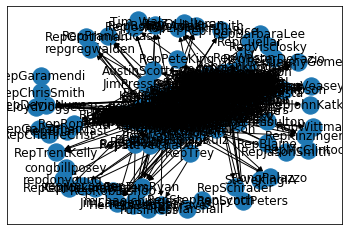

In [14]:
nx.draw_networkx(G)

## Exercise 2: Visualize the network of retweets and investigate differences between the parties

* Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and nodes coordinates from the force atlas algorithm. *Hint: use an undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements.* Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the node-size to be proportional to total degree. 

* Compare the network of Retweets with the network of Wikipedia pages (generated during Week 5). Do you observe any differences? How do you explain them?

* Now set the node-size tob proportional to betweenness centrality. Do you observe any changes?

* Repeat the point above using eigenvector centrality. Again, do you see a difference? Can you explain why based on what eigenvector centrality measures?

* Who are the three nodes with highest degree within each party? And wbat is their eigenvector centrality? And their betweenness centrality?

* Plot (on the same figure) the distribution of outgoing strength for the republican and democratic nodes repectively (i.e. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?

* Find the 3 members of the republican party that have retweeted tweets from democratic members most often. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

## Exercise 3: Community detection

* Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network (Week 7)? Comment on your result.

* Visualize the network, using the Force Atlas algorithm. This time assign each node a different color based on their *community*. Describe the structure you observe.

* Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). 

* Use the confusion matrix to explain how well the communities you've detected correspond to the parties. Consider the following questions
  * Are there any republicans grouped with democrats (and vice versa)?
  * Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

# Part 2: What do republican and democratic members tweet about?

## Exercise 4: TF-IDF of the republican and democratic tweets
We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:

* **Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.**

*define a function to parse the tweets of ONE member of the house*

In [15]:
def find_preprocess_tweets(path):
        
    # first, read the tweets of a particular member
    # io module is chosen for its encoding parameter as utf-8 encoding is needed
    text = io.open(path, mode="r", encoding="utf-8").read()
    
    # replace newline character symbols in the text with a space
    text = re.sub(r'\n', ' ', text)
    
    # remove urls in the text
    # urls have little use in gathering insight into house members' tweet patterns
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # replace word character symbols in the text with a space
    text = re.sub(r'/w', ' ', text)
        
    return text

*define a funciton to tokenize text*

In [16]:
def tokenize(text):
    word_tokens = nltk.tokenize.word_tokenize(text) # tokenize text
    return word_tokens

**1. Exclude the twitter handles of other members.**

*We are not quite sure of what this subtask is trying to achieve. If we do as what the task askes for, i.e. remove twitter handles of members of the opposing party, then what are left are:*
1. *handles of members of the same party*, 
2. *handles of users not belonging to any of the parties, and* 
3. *tweet content* 

*Point 1. and 2. are unlikely to give us insight into what the person tweets about, as they are just handles (usernames) which are not part of the tweets.*
<br>
<br>
*Therefore, our group has decided to remove all handles, i.e. `@username` from the text, and focus only on the tweet content itself*
<br>
<br>
*Please let us know if you interpret this subtask in a different way. We'd love to hear your thoughts on this!*

In [17]:
def exclude_twitter_handles(text):
    
    # remove retweet handles (RT @originalAuthor: )
    text = re.sub('RT @[a-zA-Z0-9_]+: ', '', text)
    
    # remove general 'at's (@username)
    text = re.sub('@[a-zA-Z0-9_]+', '', text)
    
    return text

**2. Exclude punctuation.**

In [18]:
# obtain a list of punctuations for later use
punctuations = [i for i in string.punctuation]
punctuations

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

**3. Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).**

In [19]:
# obtain a list of stop words for later use
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

**4. Exclude numbers (since they're difficult to interpret in the word cloud).**

In [20]:
# function to check if a string contains numbers
def exclude_numbers(text):
    return re.sub(r'\d', '', text)

**5. Set everything to lower case.**

In [21]:
def set_to_lower_case(text):
    return text.lower()

*putting everything together:*

In [25]:
# define a function to process tweets of ONE member

def process_one_member(path):
    
    # parse and process the text
    text = find_preprocess_tweets(path) # parse the tweets of ONE member of the house
    text = exclude_twitter_handles(text) # exclude twitter handles
    text = exclude_numbers(text) # exclude numbers
    text = set_to_lower_case(text) # set to lowercase
       
    # add punctuations and stop words to one list
    to_be_removed = punctuations + stop_words
    
    # tokenize the text
    word_tokens = tokenize(text)
        
    # remove punctuations and stop words
    word_tokens = [w for w in word_tokens if not w in to_be_removed]
    
    return word_tokens

In [26]:
# initialise two empty tokens
democratic_tokens = []
republican_tokens = []

In [27]:
# define a function to process tweets of ALL members, based on their parties

def process_all_members():
       
    # iterate through all files in the folder
    for file in glob.glob("tweets_2019/*"):
        
        # extract the wikiname of the house member
        name = file[12:]
        
        # obtain the path of each file
        path = "tweets_2019/" + name
        
        # tokenize the tweets of each house member
        word_tokens = process_one_member(path)
        
        # obtain the member's party
        party = wikiName_party_dic[name]
        
        # add his tweets tokens to the respective party token list
        if party == "Democratic":
            democratic_tokens.extend(word_tokens)
#             democratic_documents.append([" ".join(word_tokens),])
        elif party == "Republican":
            republican_tokens.extend(word_tokens)
#             republican_documents.append([" ".join(word_tokens),])

In [28]:
# run the function to obtain the tokens of democratic tweets and republican tweets
process_all_members()

In [29]:
democratic_tokens

['weremember',
 '😶🤐',
 '🙏🏼',
 "'s",
 'repulsive',
 'compare',
 'house',
 "'s",
 'impeachment',
 'investigation',
 'lynching',
 'mr.',
 'president',
 '…',
 'domestic',
 'violence',
 'harm',
 'one',
 'us',
 'loved',
 'ones',
 'former',
 '--',
 'dispatcher',
 'know',
 'firsthand',
 'm…',
 'optimism',
 'mean',
 'blind',
 'actual',
 'reality',
 'situation',
 'means',
 'maintaining',
 'positive',
 'spirit',
 'continue…',
 'felicitamos',
 'por',
 'la',
 'realización',
 'del',
 'ix',
 'foro',
 'centroamericano',
 'de',
 'donantes',
 'en',
 'tegucigalpa',
 'honduras',
 'por',
 'pro…',
 'congratulations',
 'hosting',
 'th',
 'annual',
 'central',
 'america',
 'donors',
 'forum',
 'tegucigalpa',
 'honduras',
 'for…',
 'así',
 'lucen',
 'esta',
 'hora',
 'la',
 'calles',
 'del',
 'centro',
 'histórico',
 'de',
 'quito',
 'ecuador',
 'cientos',
 'de',
 'personas',
 'de',
 'los',
 'barrios',
 'con',
 'el',
 'apoyo',
 'de',
 'empr…',
 'desafortunadamente',
 'la',
 'justicia',
 'es',
 'un',
 'lujo',
 

In [30]:
republican_tokens

['democrats',
 'since',
 'walked',
 'pennsylvania',
 'avenue',
 'january',
 'sp…',
 'meet',
 'w/',
 'lt.',
 'gen.',
 'bruce',
 'wright',
 'president',
 'air',
 'force',
 'association',
 'afternoon',
 'airmenforlife',
 'house',
 'passed',
 'support',
 'act',
 'yr',
 'ago',
 'house+senate',
 'sent',
 'sweeping',
 'bipartisan',
 'bill',
 '-most',
 'significant…',
 'voted',
 'yes',
 'house',
 'measure',
 'censure',
 'intelligence',
 'committee',
 'chairman',
 'schiff',
 '’',
 'abusing',
 'power',
 'c…',
 'kicked',
 'week',
 'speaking',
 'national',
 'association',
 'tower',
 'erectors',
 '...',
 'plus',
 'would',
 'wonderful',
 'chance',
 'showcase',
 'small',
 'town',
 'american',
 'spirit',
 'worldwide…',
 'perhaps',
 'host',
 'next',
 'year',
 '’',
 'g',
 'somewhere',
 'appalachia',
 'ohio',
 'world',
 'leaders',
 'could',
 'see',
 'firsthan…',
 'studio',
 'happening',
 'soon',
 'tomorrow',
 'lot',
 'going',
 'discuss',
 'time',
 'slot',
 'national',
 'media',
 'all-in',
 'focusing',
 '

* Compute the TF-IDF for each document.

TF (term frequency) is defined to be 

count of term in document / number of words in document

tf(t,d) = count of t in d / number of words in d

In [35]:
def term_frequency(token_list):
    tf={}
    for word in token_list:
        if word in tf:
            tf[word] += 1
        else:
            tf[word] = 1
    for key in tf.keys():
        tf[key] = tf[key]/len(token_list)
    return tf

IDF (inverse document frequency) is defined to be

log ( Total number of documents / (occurrence term in documents + 1) )

log(N/(df+1))

In [41]:
def inverse_document_frequency(token_list):
    idf={}
    for word in token_list:
        if word in idf:
            idf[word] += 1
        else:
            idf[word] = 1
    for key in idf.keys():
        idf[key] = math.log(1/(idf[key]+1))
    return idf

In [42]:
inverse_document_frequency(republican_tokens)

{'democrats': -7.129297548929373,
 'since': -5.966146739123692,
 'walked': -2.3978952727983707,
 'pennsylvania': -3.891820298110627,
 'avenue': -1.791759469228055,
 'january': -3.4339872044851463,
 'sp…': -2.5649493574615367,
 'meet': -5.966146739123692,
 'w/': -5.961005339623274,
 'lt.': -3.2188758248682006,
 'gen.': -2.995732273553991,
 'bruce': -2.5649493574615367,
 'wright': -2.4849066497880004,
 'president': -6.959398512133975,
 'air': -4.927253685157205,
 'force': -5.170483995038151,
 'association': -4.897839799950911,
 'afternoon': -5.204006687076795,
 'airmenforlife': -0.6931471805599453,
 'house': -7.517520850603031,
 'passed': -6.115892125483034,
 'support': -6.660575149839686,
 'act': -6.881411303642535,
 'yr': -2.4849066497880004,
 'ago': -5.926926025970411,
 'house+senate': -0.6931471805599453,
 'sent': -4.624972813284271,
 'sweeping': -2.0794415416798357,
 'bipartisan': -6.47543271670409,
 'bill': -6.761572768804056,
 '-most': -1.791759469228055,
 'significant…': -0.69314

* Now, create word-cloud for each party. Are these topics less "boring" than the Wikipedia topics from Week 7? Why?  Comment on the results.

# Part 3: Sentiment analysis

## Exercise 5: Sentiment over the Twitter data

* Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.

* Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

* Create two lists: one containing tweets by democratic members, and the other with the tweets of republican members. Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?

* Compute the average $m$ and standard deviation $\sigma$  of the Tweets sentiment (considering tweets by both republican and democrats).

* Now only tweets with sentiment lower than $m-2\sigma$. We will refer to them as *negative* tweets.  Build a list containing *negative* tweets written by democrats, and one for republicans. Compute the TF-IDF on these two lists. Create a word-cloud for each of them. Are there differences between the positive content posted by republican and democrats?

* Repeat the point above, but considering _positive_ tweets (e.g. with sentiment larger than $m+2\sigma$). Comment on your results.